In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

## allow the import of the MovieData class
import sys
import os
path = os.path.abspath(os.getcwd()) + '/../data_load'
sys.path.insert(0, path)

from movie_data import MovieData

%matplotlib inline

In [4]:
moviedata = MovieData(min_genre_frequency=0.05)
print(moviedata.genre_labels)

['Action' 'Adventure' 'Comedy' 'Crime' 'Drama' 'Romance' 'Thriller']


In [5]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

# LDA

In [6]:
n_features = 5000
n_top_words = 20

count_vectorizor = CountVectorizer(
        max_df=0.95, 
        min_df=2,
        max_features=n_features,
        stop_words='english'
)
count = count_vectorizor.fit_transform(moviedata.plots)
count_feature_names = count_vectorizor.get_feature_names()

lda = LatentDirichletAllocation(
        n_topics=7, max_iter=5,
        learning_method='online',
        learning_offset=50.,
        random_state=0
)
Z = lda.fit_transform(count)

print_top_words(lda, count_feature_names, n_top_words)

Topic #0:
charlie eddie king prince invention cabin harold 1950s charles embark bennett chloe beverly royal boat hills lily wallace sea mistaken
Topic #1:
world harry god evil earth vegas save terrible human jay new cult thief real picture radio rare horrific annie team
Topic #2:
team crew money group nick ship black captain mike earth angeles gang los new sam million member hunter plan decide
Topic #3:
man life young family town father world son new love help story time old years lives woman home death girl
Topic #4:
war murder group american police world agent secret new man young drug killer country case help years bond detective mission
Topic #5:
film music documentary rock early singer band star park movie dance set director hollywood danny musical world lee club comedy
Topic #6:
life new school friends love old family friend time mother day year young just high father best daughter finds woman



# TF-IDF

In [7]:
vectorizer = TfidfVectorizer(
    max_df=0.7, 
    analyzer='word',
    ngram_range=(1, 1),
    max_features=n_features,
    stop_words='english')

X = vectorizer.fit_transform(moviedata.plots)
# vectorizer.get_feature_names()

In [8]:
pca = PCA(n_components=20)
XX = pca.fit_transform(X.todense())

## Combined

In [9]:
combined_features = np.hstack([Z, XX])

X_train, X_test, y_train, y_test = train_test_split(
    combined_features, 
    moviedata.one_hot_genres, 
    test_size=0.4, 
    random_state=42
)

# Linear Regression

In [10]:
genre_coeffs = []
scores = []

for i, label in enumerate(moviedata.genre_labels):
    coeffs = np.linalg.lstsq(X_train, y_train[:, i])[0]
    genre_coeffs.append(coeffs)
    y_pred_probs = np.dot(X_test, coeffs)
    y_pred = np.array(y_pred_probs > 0.25, dtype=int)
    score = f1_score(y_test[:, i], y_pred)
    scores.append(score)
    print("Genre: {}, Score: {:.2f}".format(label, score))
    
print('Mean f1 score: {:.3f}'.format(np.mean(scores)))

Genre: Action, Score: 0.59
Genre: Adventure, Score: 0.51
Genre: Comedy, Score: 0.59
Genre: Crime, Score: 0.52
Genre: Drama, Score: 0.69
Genre: Romance, Score: 0.50
Genre: Thriller, Score: 0.35
Mean f1 score: 0.537


# Logistic Regression

Genre: Action, Score: 0.58
Genre: Adventure, Score: 0.48
Genre: Comedy, Score: 0.58
Genre: Crime, Score: 0.48
Genre: Drama, Score: 0.67
Genre: Romance, Score: 0.48
Genre: Thriller, Score: 0.36
Mean f1 score: 0.519


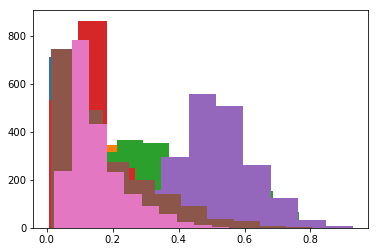

In [11]:
scores = []

for i, label in enumerate(moviedata.genre_labels):
    clf = LogisticRegression()
    clf.fit(X_train, y_train[:, i])
    y_pred_probs = clf.predict_proba(X_test)[:, 1]
    plt.hist(y_pred_probs)
    y_pred = np.array(y_pred_probs > np.mean(y_pred_probs), dtype=int)
    score = f1_score(y_test[:, i], y_pred)
    scores.append(score)
    print("Genre: {}, Score: {:.2f}".format(label, score))
    
print('Mean f1 score: {:.3f}'.format(np.mean(scores)))

# Random Forrest

In [12]:
clf = RandomForestClassifier(n_estimators=25, max_features='auto', max_depth=None)
clf.fit(X_train, y_train)
y_guess_probs = clf.predict_proba(X_test)
y_guess = clf.predict(X_test)

In [13]:
scores = f1_score(y_test, y_guess, average=None)

In [14]:
print(np.mean(scores))

0.37404452888


In [15]:
# guess randomly
np.mean(f1_score(y_test, np.random.randint(0, 2, y_test.shape), average=None))

0.33360044323513044